In [6]:
# Import libraries
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay, f1_score, recall_score, precision_score

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, StratifiedGroupKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.inspection import permutation_importance
from joblib import dump, load

from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

SEED = 123

np.random.seed(SEED)
random.seed(SEED)

In [11]:
# Load the dataset
CKD_INDIA_PATH = Path("../data/Public_Datasets/CKD_UAE_Dataset/ChronicKidneyDisease_EHRs_from_AbuDhabi.csv")
df = pd.read_csv(CKD_INDIA_PATH)

df.head()

,Sex,AgeBaseline,HistoryDiabetes,HistoryCHD,HistoryVascular,HistorySmoking,HistoryHTN,HistoryDLD,HistoryObesity,DLDmeds,...,ACEIARB,CholesterolBaseline,CreatinineBaseline,eGFRBaseline,sBPBaseline,dBPBaseline,BMIBaseline,TimeToEventMonths,EventCKD35,TIME_YEAR
0,0,64,0,0,0,0,1,1,1,1,...,0,4.8,59.0,93.3,144,87,40,98,0,8
1,0,52,0,0,0,0,1,1,1,0,...,0,6.4,52.0,105.8,148,91,45,106,0,9
2,0,56,0,0,0,0,1,1,1,1,...,0,6.4,57.0,99.8,149,86,41,88,0,7
3,0,58,0,0,0,0,0,1,1,1,...,0,5.1,65.0,90.3,116,68,32,103,0,9
4,0,63,1,0,0,0,1,1,1,1,...,1,5.0,70.0,79.7,132,63,31,105,0,9


In [3]:
# Clean the column names
df.columns = [col.strip() for col in df.columns]
df.columns

Index(['Sex', 'AgeBaseline', 'HistoryDiabetes', 'HistoryCHD',
       'HistoryVascular', 'HistorySmoking', 'HistoryHTN', 'HistoryDLD',
       'HistoryObesity', 'DLDmeds', 'DMmeds', 'HTNmeds', 'ACEIARB',
       'CholesterolBaseline', 'CreatinineBaseline', 'eGFRBaseline',
       'sBPBaseline', 'dBPBaseline', 'BMIBaseline', 'TimeToEventMonths',
       'EventCKD35', 'TIME_YEAR'],
      dtype='object')

In [4]:
# Get variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sex                  491 non-null    int64  
 1   AgeBaseline          491 non-null    int64  
 2   HistoryDiabetes      491 non-null    int64  
 3   HistoryCHD           491 non-null    int64  
 4   HistoryVascular      491 non-null    int64  
 5   HistorySmoking       491 non-null    int64  
 6   HistoryHTN           491 non-null    int64  
 7   HistoryDLD           491 non-null    int64  
 8   HistoryObesity       491 non-null    int64  
 9   DLDmeds              491 non-null    int64  
 10  DMmeds               491 non-null    int64  
 11  HTNmeds              491 non-null    int64  
 12  ACEIARB              491 non-null    int64  
 13  CholesterolBaseline  491 non-null    float64
 14  CreatinineBaseline   491 non-null    float64
 15  eGFRBaseline         491 non-null    flo

In [5]:
# Drop target columns
col_to_drop = [
    "TimeToEventMonths",
    "EventCKD35",
    "TIME_YEAR"
]

y = df.EventCKD35.copy()
X = df.drop(columns=col_to_drop)

print(X.shape, y.shape)

(491, 19) (491,)


In [298]:
# Create test dataset
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=SEED)

# Create a stratified 
splits = kf.split(X, y, groups=X.HistoryDiabetes)
train_idx, test_idx = next(splits)

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


print(X_train.shape, X_test.shape)

print("TRAIN POSITIVE RATIO:", y_train.mean())
print("TEST POSITIVE RATIO :", y_test.mean())

print("TRAIN DIABETES RATIO:", X_train.HistoryDiabetes.mean())
print("TEST DIABETES RATIO :", X_test.HistoryDiabetes.mean())

print("TRAIN HYPERTENSION RATIO:", X_train.HistoryHTN.mean())
print("TEST HYPERTENSION RATIO :", X_test.HistoryHTN.mean())

(409, 19) (82, 19)
TRAIN POSITIVE RATIO: 0.11491442542787286
TEST POSITIVE RATIO : 0.10975609756097561
TRAIN DIABETES RATIO: 0.43031784841075793
TEST DIABETES RATIO : 0.47560975609756095
TRAIN HYPERTENSION RATIO: 0.6919315403422983
TEST HYPERTENSION RATIO : 0.6341463414634146


In [299]:
# Scale data for linear models
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_variables = X.select_dtypes(include=['float64', 'int64']).columns

X_train_scaled.loc[:, numeric_variables] = scaler.fit_transform(X_train[numeric_variables])
X_test_scaled.loc[:, numeric_variables] = scaler.transform(X_test[numeric_variables])

In [301]:
def compare_models(models: list, X_train, y_train, X_test, y_test, threshold=0.5):

    ax = plt.subplot(111)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
    
    for model in models:
        model_name = type(model).__name__

        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        print(f'Cross Validated ROC AUC for {model_name}: %.3f' % np.mean(scores))

        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)
        preds = (probs[:, 1]>=threshold).astype(int)

        print(f"Test accuracy for {model_name}: {accuracy_score(y_test, preds):.3f}")
        print(f"Test F1 score for {model_name}: {f1_score(y_test, preds):.3f}\n")

        fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
        display.plot(ax=ax)
    
    plt.show()


# BASELINE MODELS

#### Baseline model with all the relevant features and entries. No data cleaning performed

### Without oversampling

In [302]:
models = [DummyClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]

Cross Validated ROC AUC for DummyClassifier: 0.500
Test accuracy for DummyClassifier: 0.890
Test F1 score for DummyClassifier: 0.000

Cross Validated ROC AUC for LogisticRegression: 0.868
Test accuracy for LogisticRegression: 0.854
Test F1 score for LogisticRegression: 0.250

Cross Validated ROC AUC for DecisionTreeClassifier: 0.641
Test accuracy for DecisionTreeClassifier: 0.841
Test F1 score for DecisionTreeClassifier: 0.381

Cross Validated ROC AUC for RandomForestClassifier: 0.868
Test accuracy for RandomForestClassifier: 0.878
Test F1 score for RandomForestClassifier: 0.167



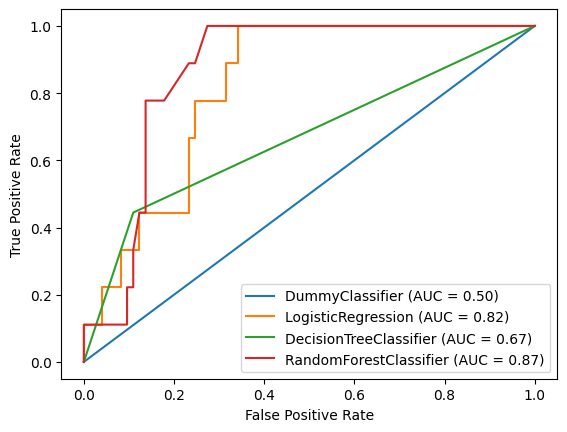

In [303]:
compare_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

### With SMOTE oversampling

Cross Validated ROC AUC for Pipeline: 0.872
Test accuracy for Pipeline: 0.829
Test F1 score for Pipeline: 0.222



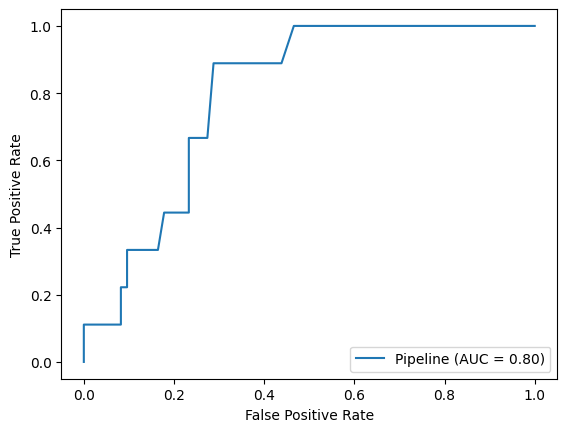

In [306]:
model = RandomForestClassifier()
over = SMOTE()
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

compare_models([pipeline], X_train, y_train, X_test, y_test)

## Get Feature Importances

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

<Axes: ylabel='cols'>

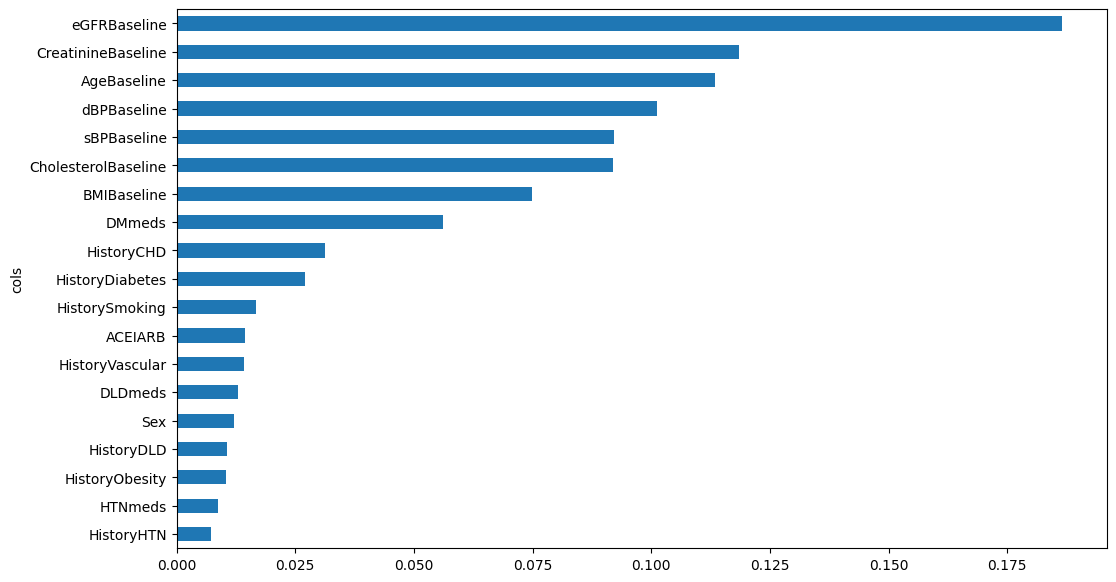

In [8]:
def rf_feat_importance(m):
    return pd.DataFrame({'cols':m.feature_names_in_, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)
    
rf_feat_importance(model).plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [45]:
import shap
from random import randint

data_for_prediction = X_test.iloc[randint(0, X_test.shape[0])]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [29]:
probs = model.predict_proba(X_test)
preds = (probs[:, 1]>=0.115).astype(int)

print(f"Test accuracy: {accuracy_score(y_test, preds):.3f}")
print(f"Test F1 score: {f1_score(y_test, preds):.3f}")
print(f"Test Recall: {recall_score(y_test, preds):.3f}")
print(f"Test Precision: {precision_score(y_test, preds):.3f}\n")

Test accuracy: 0.756
Test F1 score: 0.474
Test Recall: 1.000
Test Precision: 0.310



In [5]:
dump(model, '..\\models\\RandomForest.joblib') 

NameError: name 'model' is not defined

In [7]:
model = load('..\\models\\RandomForest.joblib')

In [22]:
def calculate_ckd_epi_gfr(age, serum_creatinine, is_female=False, is_black=False):
    if is_female:
        kappa = 61.9
        alpha = -0.329
    else:
        kappa = 79.6
        alpha = -0.411
    
    if is_black:
        race_factor = 1.159
    else:
        race_factor = 1.0
    
    gfr = 141 * min(serum_creatinine / kappa, 1) ** alpha * max(serum_creatinine / kappa, 1) ** -1.209 * 0.993 ** age * 1.018 ** is_female * race_factor
    
    return gfr

In [23]:
df.iloc[0]

Sex                      0.0
AgeBaseline             64.0
HistoryDiabetes          0.0
HistoryCHD               0.0
HistoryVascular          0.0
HistorySmoking           0.0
HistoryHTN               1.0
HistoryDLD               1.0
HistoryObesity           1.0
DLDmeds                  1.0
DMmeds                   0.0
HTNmeds                  1.0
ACEIARB                  0.0
CholesterolBaseline      4.8
CreatinineBaseline      59.0
eGFRBaseline            93.3
sBPBaseline            144.0
dBPBaseline             87.0
BMIBaseline             40.0
TimeToEventMonths       98.0
EventCKD35               0.0
TIME_YEAR                8.0
Name: 0, dtype: float64

In [24]:
calculate_ckd_epi_gfr(64, 59, is_female=True)

93.01965106570779